# Purpose

This notebook is mostly designed to help individuals understand the class structure here. Its been designed with the goal that a person could come in with their own type of distribution, and adjust it based on the base class, and run it for themselves.

First, we'll go through the standard Chinese Restaurant Table (Dirichlet Multinomial). 

In [1]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Data/choroid-plexus/new_annotations.h5ad")
adata = adata[adata.obs["Cell.Subtype"].ne("Doublet")]
adata = adata[adata.X.sum(axis=1) > 300]
sc.pp.highly_variable_genes(adata, flavor="seurat_v3")

counts = adata.X.todense()
size_factors = np.log(counts.sum(axis=1) / counts.sum(axis=1).mean())

/home/jhaberbe/Projects/Personal/chinese_restaurant_process/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


## ChineseRestaurantTable

This represents each of the classes that we add to the generative process. At its base, it will have the following properties:

- `data`: 
    - A np.array of shape (N, D). The data is a reference to the count matrix we perform inference on, which tracks which elements have been added or removed. This makes tracking table size easier, which allows us to know when we can delete a table.
- `members`: 
    - a set that will contain the indices that we assign to the table. Mostly for tracking table size and computing the table size prior.

The methods for this class include:
- `add_member`: 
    - adds a specified index.
- `remove_member`: 
    - removes a specified index from the table.
- `log_likelihood`: 
    - a function that computes the log likelihood for a specified __index__, and it comes with a `posterior` keyword argument (boolean type), which tells us whether we're computing the log likelihood with an update (as if we included it in the class) or not. Generally, posterior = True is for training, posterior = False is for inference.
- `predict`: 
    - given a new count vector, this computes the log likelihood without a posterior update. This is strictly for new data / inference. 

In [2]:
class ChineseRestaurantTable:
    """Base for Chinese Restaurant Tables"""

    def __init__(self, data):
        self.data = data
        self.members = set()
    
    def add_member(self, index: int):
        if index not in self.members:
            self.members.add(index)

    def remove_member(self, index: int):
        if index in self.members:
            self.members.remove(index)

    def log_likelihood(self, index: int, posterior: bool = False):
        pass

    def predict(self, count: np.ndarray):
        pass

### DirichletMultinomialTable

As an example, the following is an implementation of our ChineseRestaurantTable using a DirichletMultinomial count distribution. 

The `add_member` and `remove_member` methods are now also performing the posterior updates for our collapsed gibbs sampling. 

We have an additional `_dirichlet_multinomial_log_likelihood` that is used for both the `log_likelihood` and `predict` method. This is probably best practice when implementing this yourself.

Note, when you implement a different distribution, you'll need to figure out how to formulate, store, and update your distribution. For dirichlet distributions, its very easy (`self.concentration`, with addition and subtraction of the count vector as we add and remove samples). Others (negative binomial distributions, for example) will require more work. We'll provide an example later on.

In [3]:
import numpy as np
from scipy.special import gammaln

class DirichletMultinomialTable(ChineseRestaurantTable):
    def __init__(self, data: np.ndarray):
        self.data = data
        self.members = set()
        self.concentration = np.ones((1, self.data.shape[1]))  # shape: (D,)

    def add_member(self, index: int):
        if index not in self.members:
            self.members.add(index)
            self.concentration += self.data[index]

    def remove_member(self, index: int):
        if index in self.members:
            self.members.remove(index)
            self.concentration -= self.data[index]

    def _dirichlet_multinomial_log_likelihood(self, count: np.ndarray, concentration: np.ndarray) -> float:
        N = np.sum(count)
        return (
            gammaln(N + 1)
            - np.sum(gammaln(count + 1))
            + gammaln(np.sum(concentration))
            - gammaln(np.sum(concentration) + N)
            + np.sum(gammaln(count + concentration) - gammaln(concentration))
        )

    def log_likelihood(self, index: int, posterior: bool = False):
        x = self.data[index]
        concentration = self.concentration + x if posterior else self.concentration
        return self._dirichlet_multinomial_log_likelihood(x, concentration)

    def predict(self, count: np.ndarray):
        return self._dirichlet_multinomial_log_likelihood(count, self.concentration)

### ChineseRestaurantProcess

The Chinese Restaurant Process class should support any distribution, as long as it's formulated as specified above. Class properties include:

- `data`
    - same as before, it would be the np.array of shape (N, D) 
- `classes`
    - This is just a dictionary that stores each of the ChineseRestaurantTable objects.
- `assignments`
    - This is a list with assignments for all current objects, which makes tracking and updating much easier. Values either correspond to a value in the classes, and -1 if its unassigned.
- `expected_number_of_classes`
    - This is an integer, and is used to inform the value of `_alpha`, which is the prior determining how likely new tables are to be generated.

- `_alpha`:
    - Our prior on new tables, larger numbers means new tables are more likely to be generated. This corresponds to (K / np.log(N)), for K classes and N samples.
- `_table_type`:
    - By default, this is a `DirichletMultinomialTable`, but when you implement new classes you can change the class used by calling `ChineseRestaurantProcess.set_table_type(DirichletMultinomialTable)`


The following methods are available:

- `set_table_type`
    - Set the distribution you want inference to run on. Defaults to DirichletMultinomialTable.
- `generate_new_table`
    - Used during inference to generate a new table with no members (will have an uninformative prior).
- `add_table`
    - Will add a new table to the `self.classes` dictionary.
- `remove_table`
    - Will take a table, remove all the members (and reset their assignments in the global tracker), and then remove the class from the dictionary. Raises a ValueError if the class doesn't exist (should never happen during inference).
- `run`
    - Where the magic happens, full inference process. You can set how many `epochs` you'd like it to run. Honestly, even 1 epoch on a large enough dataset can do really really well.
- `predict`
    - Runs prediction on a new dataset. By default uses truncated inference, meaning only classes with at least 1% of the dataset will be included. Simply set the `min_membership` keyword argument to `0.0` in order for it to be fully BNP inference.

In [14]:
import numpy as np
from tqdm import tqdm

class ChineseRestaurantProcess:
    _table_type = DirichletMultinomialTable

    def __init__(self, data: np.array, expected_number_of_classes: int = 1):
        # Data
        self.data = data

        # Classes
        self.classes = {}
        self.assignments = [-1] * data.shape[0]

        # Expected number of classes, setting alpha prior
        self.expected_number_of_classes = expected_number_of_classes
        self._alpha = self.expected_number_of_classes / np.log(self.data.shape[0])
    
    def set_table_type(self, cls):
        self._table_type = cls
    
    def generate_new_table(self):
        return self._table_type(self.data)

    def add_table(self, table: ChineseRestaurantTable):
        # Find smallest unused lot.
        new_class_id = 0
        while new_class_id in self.classes:
            new_class_id += 1
        self.classes[new_class_id] = table
        return new_class_id

    def remove_table(self, class_id):
        if class_id in self.classes:
            for member in self.classes[class_id].members:
                self.assignments[member] = -1
            del self.classes[class_id]
        else:
            raise ValueError(f"Class ID {class_id} does not exist.")

    def run(self, epochs=1, min_membership=0.01):
        # For each epoch
        for epoch in range(epochs):
            # For each item (shuffled selection for robustness).
            for index in tqdm(np.random.permutation(self.data.shape[0])):

                # Generate new table for this round
                crp_new = self.generate_new_table()

                # Existing class log-likelihoods
                cluster_keys = list(self.classes.keys()) + ["new"]
                nlls = []
                for k in self.classes:
                    table = self.classes[k]
                    log_like = table.log_likelihood(index, posterior = True)
                    log_prior = np.log1p(len(table.members))
                    nlls.append(log_like + log_prior)

                # New table likelihood
                log_new = crp_new.log_likelihood(index, posterior = True) + np.log(self._alpha)
                nlls.append(log_new)

                # Softmax sampling
                probs = np.exp(nlls - np.max(nlls))
                probs /= probs.sum()
                sampled_idx = np.random.choice(len(probs), p=probs)
                sampled_class = cluster_keys[sampled_idx]

                # Assignment
                if sampled_class == "new":
                    new_class_id = self.add_table(crp_new)
                    self.classes[new_class_id].add_member(index)
                    self.assignments[index] = new_class_id
                else:
                    self.classes[sampled_class].add_member(index)
                    self.assignments[index] = int(sampled_class)

    def predict(self, X_new: np.ndarray, min_membership: float = 0.01) -> np.ndarray:
        if not self.classes:
            raise ValueError("No classes have been trained. Run `run()` before predicting.")

        n_total = self.data.shape[0]
        valid_classes = {
            k: v for k, v in self.classes.items()
            if len(v.members) >= min_membership * n_total
        }

        if not valid_classes:
            raise ValueError("No classes meet the minimum membership threshold.")

        class_keys = np.array(list(valid_classes.keys()))
        class_tables = [valid_classes[k] for k in class_keys]
        class_log_priors = np.log1p([len(table.members) for table in class_tables])

        assignments = np.empty(X_new.shape[0], dtype=class_keys.dtype)

        for i, x in enumerate(tqdm(X_new, desc="Predicting")):
            nlls = np.array([
                table.predict(x) + log_prior
                for table, log_prior in zip(class_tables, class_log_priors)
            ])
            assignments[i] = class_keys[np.argmax(nlls)]

        return assignments

### Inference

As an example, this is inference running on 2000 features, for around 4,000 samples. We use default parameters (expected_number_of_classes = 1, which is a good null hypothesis I guess(?)). Single iteration runs fairly quickly. Note, as the number of classes scales, the inference will get slower. Currently looking into ways to improve this.

In [15]:

X = adata[::50, adata.var.highly_variable].X.todense()
crp = ChineseRestaurantProcess(np.array(X))
crp.run(1)

100%|██████████| 3639/3639 [00:15<00:00, 235.33it/s]


In [16]:
subset = adata[::50]
subset.obs["labels"] = crp.predict(counts[::50, adata.var.highly_variable])

Predicting: 100%|██████████| 3639/3639 [00:06<00:00, 591.50it/s]
/tmp/ipykernel_249600/1177889133.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs["labels"] = crp.predict(counts[::50, adata.var.highly_variable])


Just to give a representative example of how well it "infers" class sturcture, here is an example where previous subtyping was performed using graph based (leiden) clustering.

/tmp/ipykernel_249600/3156062150.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  subset.obs.pivot_table(


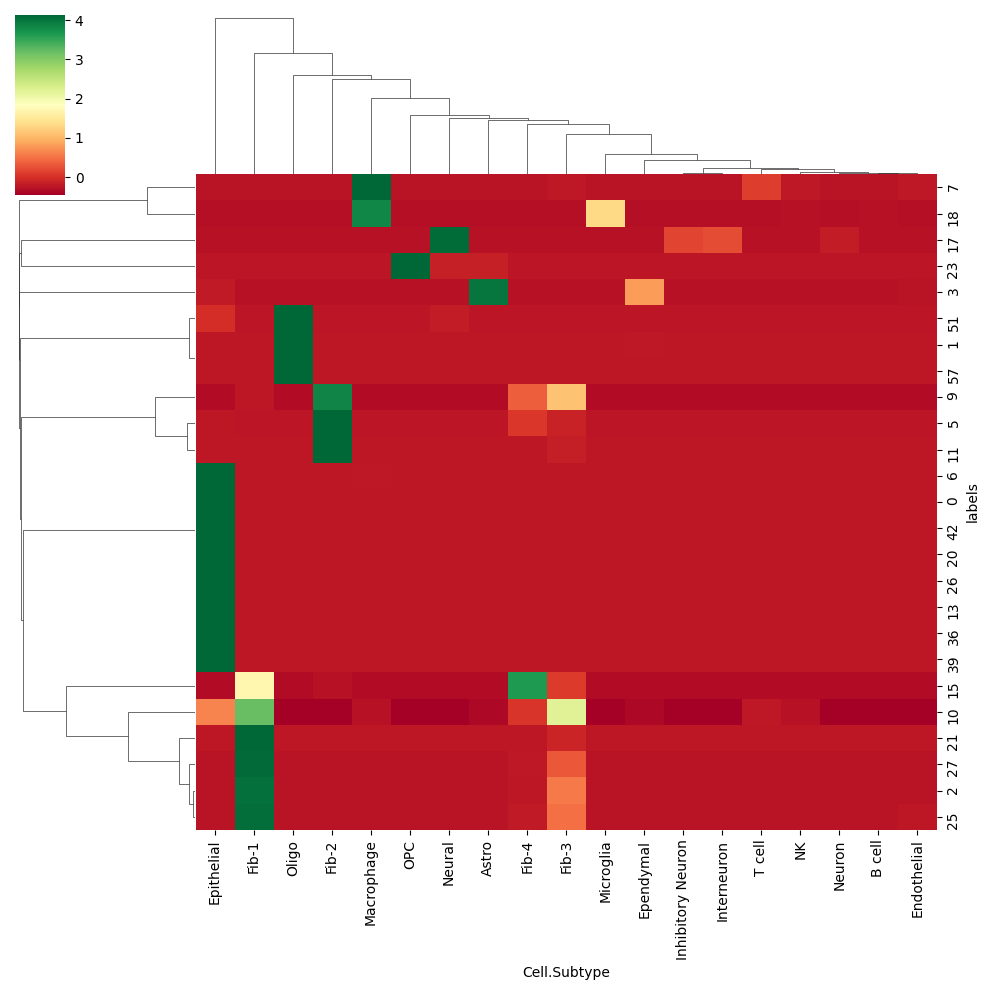

In [17]:
import seaborn as sns

sns.clustermap(
    subset.obs.pivot_table(
        index="labels",
        columns="Cell.Subtype",
        aggfunc="size"
    ),
    z_score=0,
    cmap="RdYlGn"
)

This definitely passes the first intuition test, on its face it at least performs as well as graph based clustering in distinguishing cell types, though there is overclustering that may be occuring. We could try to argue this isn't overclustering, but truly unique clustering. Lets see if these are really distinct subtypes?

/tmp/ipykernel_249600/821737644.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  epithelial_labels = subset.obs.pivot_table(


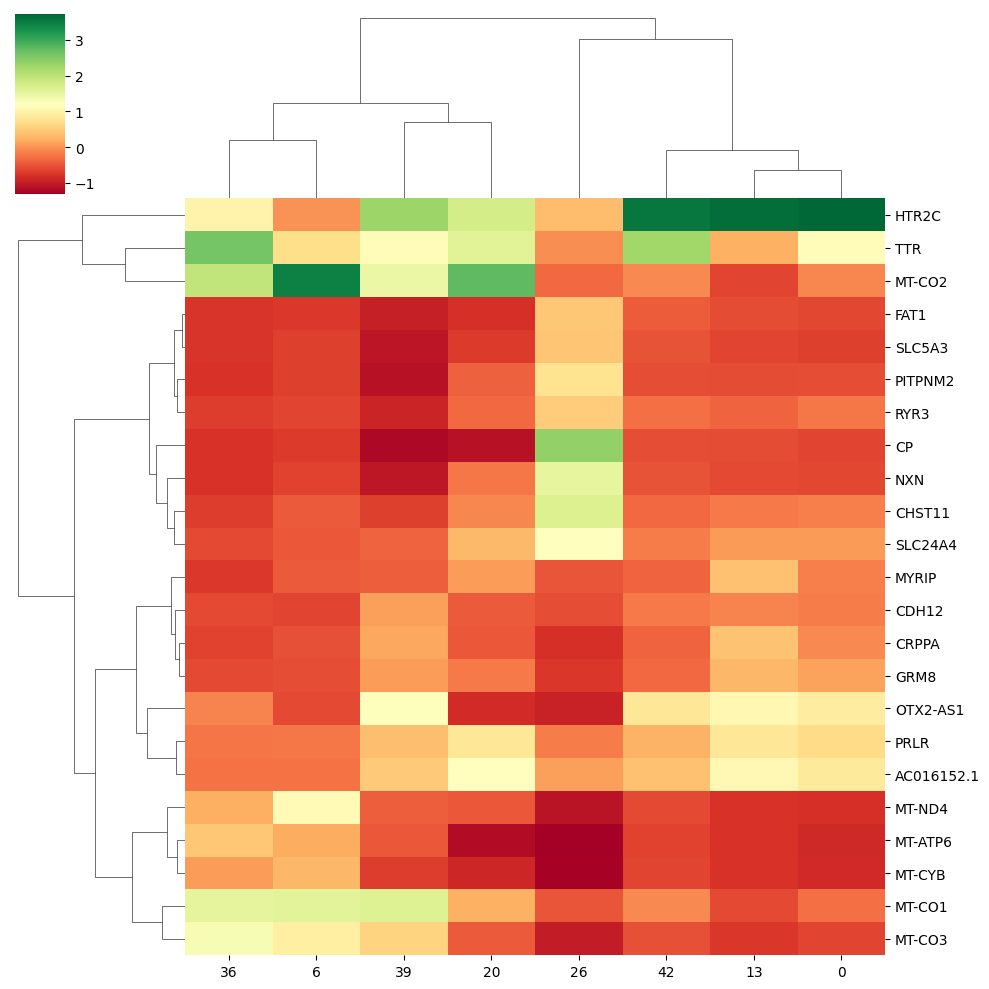

In [42]:
# For ease, we'll look at stuff with >50 cells
import numpy as np
import pandas as pd
from scipy.stats import zscore

epithelial_labels = subset.obs.pivot_table(
    index="labels",
    columns="Cell.Subtype",
    aggfunc="size"
)["Epithelial"].sort_values()

major_labels = epithelial_labels[epithelial_labels > 50].index.tolist()

concentration_parameters = pd.DataFrame({
    k: crp.classes[k].concentration.squeeze()
    for k in major_labels
}, index=adata.var_names[adata.var.highly_variable])

# Step 1: Subset rows where row sum > 500
subset_rows = concentration_parameters[concentration_parameters.sum(axis=1) > 500]

# Step 2: Compute z-scores column-wise on this subset
# zscore with axis=0 means computing z-score down columns
z_scores = zscore(subset_rows, axis=0)

# Step 3: Find columns where max z-score > 4
rows_to_keep = np.any(z_scores > 2, axis=1)

sns.clustermap(
    subset_rows.loc[rows_to_keep],
    z_score=1,
    cmap="RdYlGn",
    method="ward"
)

You can *sort* of argue that these are distinctive clusters, but truthfully I don't see this as strong evidence. Certain members of these clusters can **definitely** be improved (we'll show this later). For now though, lets see how this looks against a fairly robust and manual tuning of graph-based leiden clustering on a UMAP. 

In [43]:
subset = adata[adata.obs["Cell.Subtype"].eq("Epithelial")]
subset.obs["labels"] = crp.predict(subset[:, adata.var.highly_variable].X.todense())

sc.pp.pca(subset)
sc.external.pp.harmony_integrate(subset, key="orig.ident")
sc.pp.neighbors(subset, use_rep="X_pca_harmony")
sc.tl.umap(subset)

Predicting: 100%|██████████| 64778/64778 [01:46<00:00, 610.40it/s]
/tmp/ipykernel_249600/2051093718.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs["labels"] = crp.predict(subset[:, adata.var.highly_variable].X.todense())
2025-06-16 12:34:31,640 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-16 12:34:35,570 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-16 12:34:35,795 - harmonypy - INFO - Iteration 1 of 10
2025-06-16 12:34:46,281 - harmonypy - INFO - Iteration 2 of 10
2025-06-16 12:34:56,378 - harmonypy - INFO - Iteration 3 of 10
2025-06-16 12:35:06,833 - harmonypy - INFO - Iteration 4 of 10
2025-06-16 12:35:17,388 - harmonypy - INFO - Iteration 5 of 10
2025-06-16 12:35:28,039 - harmonypy - INFO - Converged after 5 iterations
/home/jhaberbe/Projects/Personal/chinese_restaurant_process/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress n

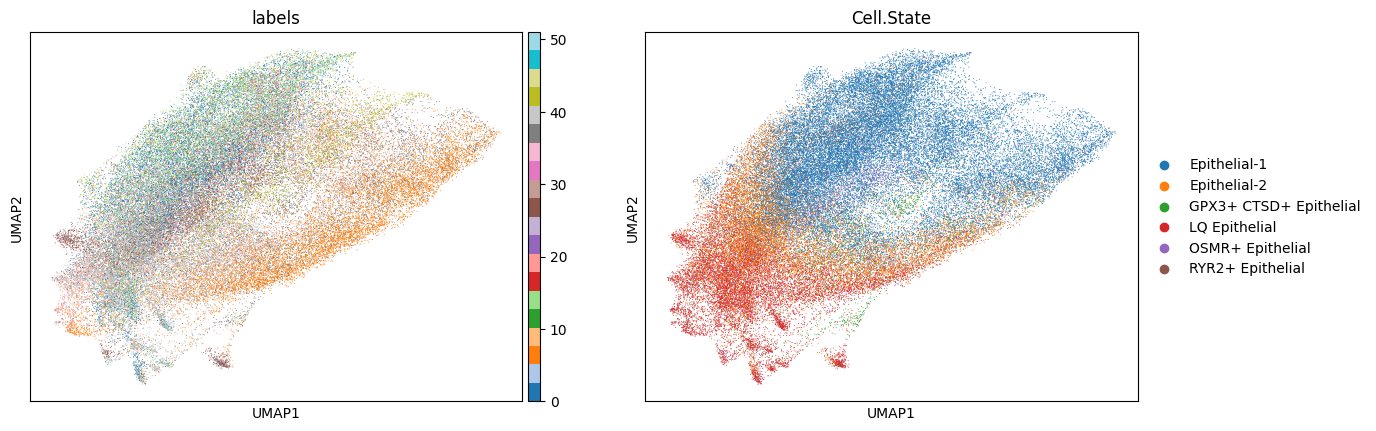

In [46]:
sc.pl.umap(subset, color=["labels", "Cell.State"], cmap="tab20")

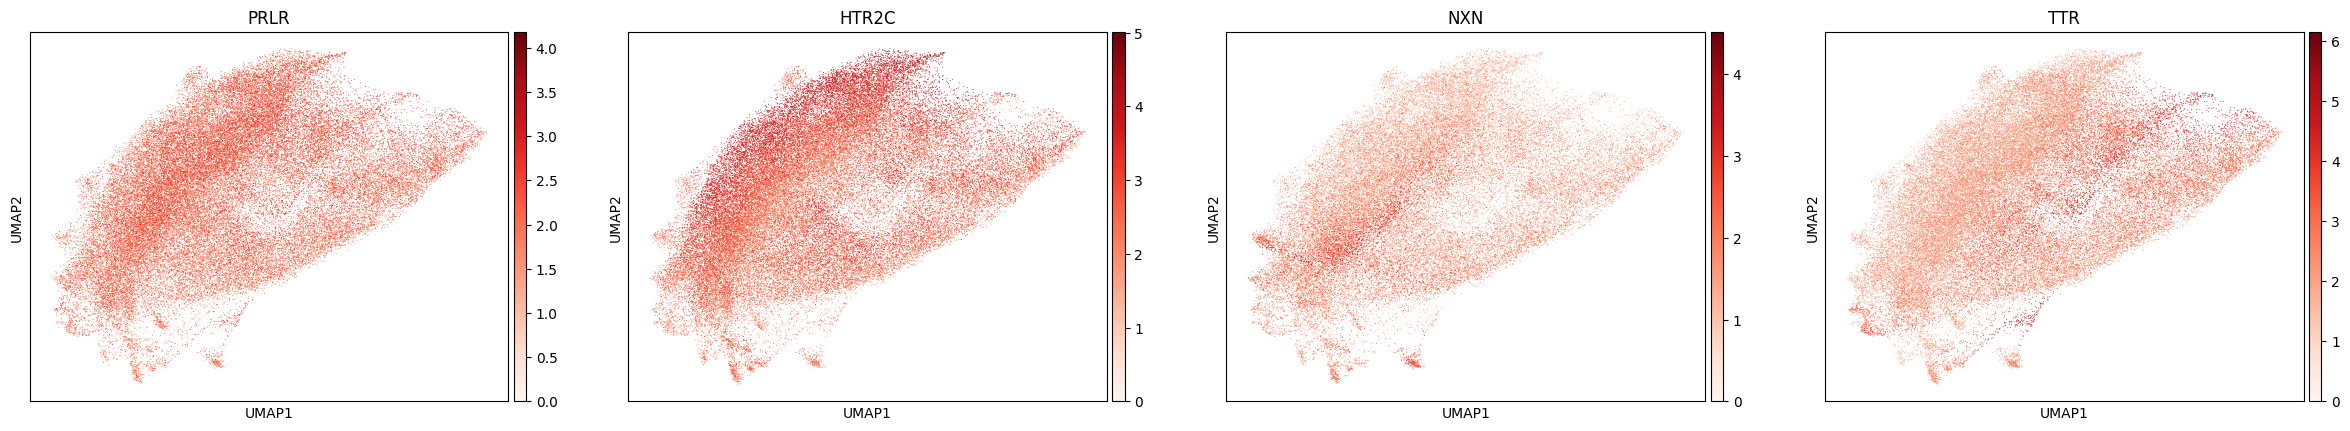

In [52]:
# Sorry for  the messy code...
subset_to_normalize = subset.copy()
sc.pp.normalize_total(subset_to_normalize)
sc.pp.log1p(subset_to_normalize)
sc.pl.umap(subset_to_normalize, color=["PRLR", "HTR2C", "NXN", "TTR"], cmap="Reds")

Though we're showing a lot of the rough edges here, I think there is a case to be made for both clustering methods and both choices of clusters. There is definitely some overclustering in our CRP, but the grouping does seem to correlate with what we see on our umap. Further, these groupings reasonably align with things that we can infer are marker genes (highly expressed, specific to our group). And kinda nicely, we get a direct probabilistic interpretation for these markers, so its sort of easier than performing post-hoc statistical tests. 

Some things for the future, in order to mitigate batch effects, might be:
- Test for which features are associated with a specific specimen, and remove them prior to running inference.
- Adding a learned covariate for each sample (hype!!! but hard) 

### How to implement your own class!

This entire infernce process should be flexible to any choice of distribution type you want. Here is an example of a Negative Binomial Distribution for each feature. I cheated and used ChatGPT to construct it.

here was the prompt:

```
I would like the same thing, but for a negative binomial distribution instead. This would involve changing the concentration property to a gamma-poisson distribution parameterization (have an alpha and beta parameter set for D features)
```

In [53]:
import numpy as np
from scipy.special import gammaln

class NegativeBinomialTable(ChineseRestaurantTable):
    def __init__(self, data: np.ndarray):
        self.data = data
        self.members = set()

        D = self.data.shape[1]
        self.alpha = np.ones(D)  # prior shape
        self.beta = np.ones(D)   # prior rate

        self.reference_total = np.mean(np.sum(data, axis=1))

    def add_member(self, index: int):
        if index not in self.members:
            self.members.add(index)
            self.alpha += self.data[index]
            self.beta += 1  # One new data point

    def remove_member(self, index: int):
        if index in self.members:
            self.members.remove(index)
            self.alpha -= self.data[index]
            self.beta -= 1

    def _gamma_poisson_log_likelihood(self, count: np.ndarray, alpha: np.ndarray, beta: np.ndarray) -> float:
        """
        Gamma-Poisson (Negative Binomial) log likelihood with size factor normalization.

        Parameters:
        - count: np.ndarray, shape (D,). Observed count vector.
        - alpha: np.ndarray, shape (D,). Gamma shape parameter.
        - beta: np.ndarray, shape (D,). Gamma rate parameter.

        Returns:
        - log-likelihood (float)
        """
        count = np.asarray(count).reshape(-1)
        alpha = np.asarray(alpha).reshape(-1)
        beta = np.asarray(beta).reshape(-1)

        # Compute size factor from total count vs. mean total count of self.data
        total = np.sum(count)
        reference_total = self.reference_total
        size_factor = total / reference_total if reference_total > 0 else 1.0
        log_sf = np.log(size_factor)

        # Gamma-Poisson log-likelihood with offset
        term1 = gammaln(count + alpha)
        term2 = -gammaln(count + 1)
        term3 = -gammaln(alpha)
        term4 = alpha * np.log(beta / (beta + np.exp(log_sf)))
        term5 = count * np.log(np.exp(log_sf) / (beta + np.exp(log_sf)))

        return np.sum(term1 + term2 + term3 + term4 + term5)

    def log_likelihood(self, index: int, posterior: bool = False):
        x = self.data[index]
        if posterior:
            alpha = self.alpha + x
            beta = self.beta + 1
        else:
            alpha = self.alpha
            beta = self.beta

        return self._gamma_poisson_log_likelihood(x, alpha, beta)

    def predict(self, count: np.ndarray):
        return self._gamma_poisson_log_likelihood(count, self.alpha, self.beta)

In [54]:
X = adata[::50, adata.var.highly_variable].X.todense()
crp = ChineseRestaurantProcess(np.array(X))
crp.set_table_type(NegativeBinomialTable)
crp.run(1)

100%|██████████| 3639/3639 [00:14<00:00, 254.01it/s]


In [55]:
subset = adata[::50, adata.var.highly_variable]
subset.obs["labels"] = crp.predict(np.array(subset.X.todense()))

Predicting: 100%|██████████| 3639/3639 [00:03<00:00, 1069.66it/s]
/tmp/ipykernel_249600/4118968208.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs["labels"] = crp.predict(np.array(subset.X.todense()))


### Looking at it again.

As it turns out, correctly specifying your distributions improves your performance! Significantly less stratification! And if we look at a UMAP...

/tmp/ipykernel_249600/3156062150.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  subset.obs.pivot_table(


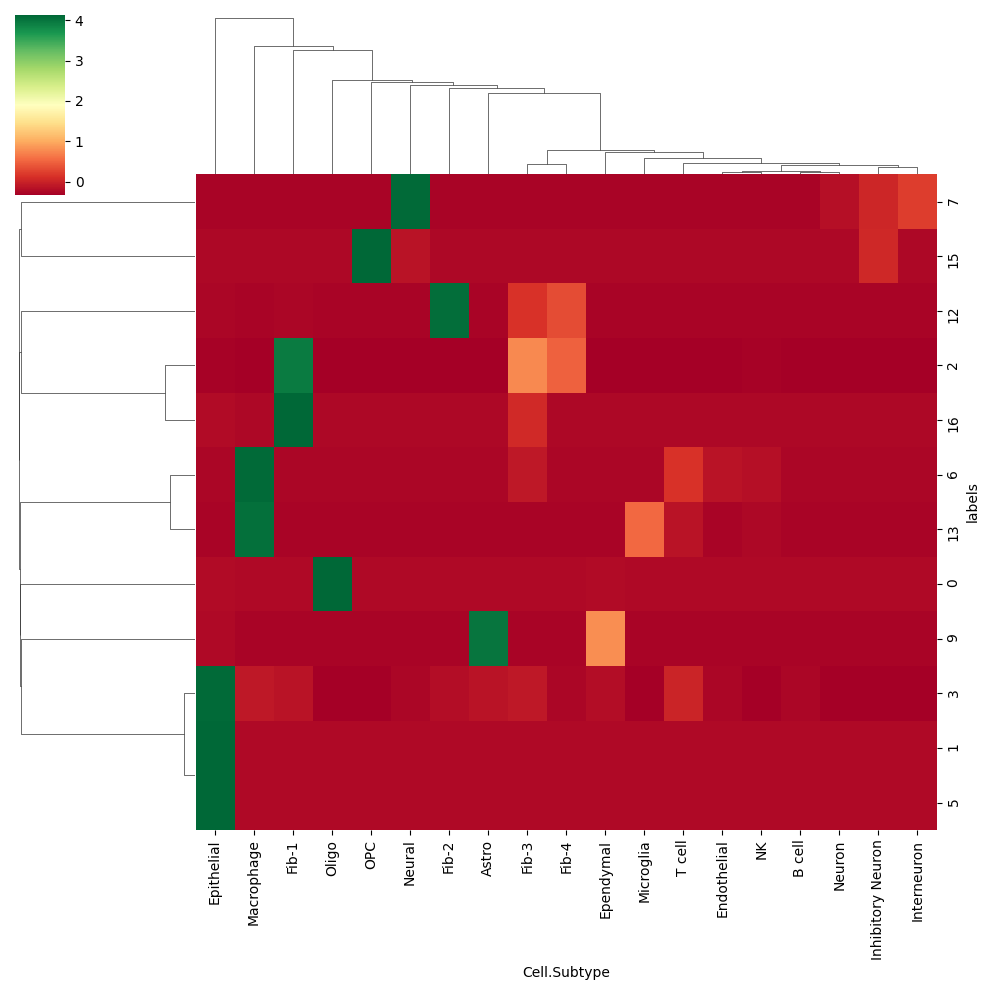

In [ ]:
import seaborn as sns

sns.clustermap(
    subset.obs.pivot_table(
        index="labels",
        columns="Cell.Subtype",
        aggfunc="size"
    ),
    z_score=0,
    cmap="RdYlGn"
)

/tmp/ipykernel_249600/3650219218.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  epithelial_labels = subset.obs.pivot_table(


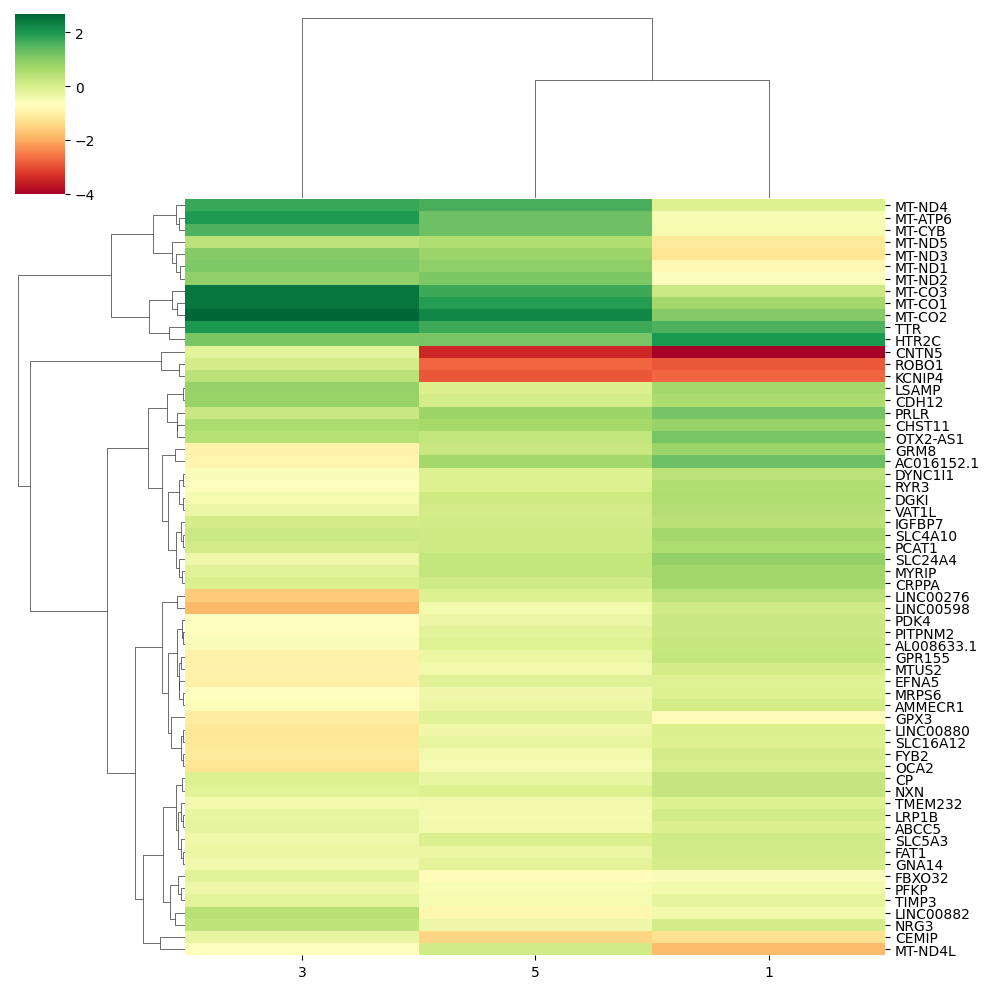

In [87]:
# For ease, we'll look at stuff with >50 cells
import numpy as np
import pandas as pd
from scipy.stats import zscore

epithelial_labels = subset.obs.pivot_table(
    index="labels",
    columns="Cell.Subtype",
    aggfunc="size"
)["Epithelial"].sort_values()

major_labels = epithelial_labels[epithelial_labels > 50].index.tolist()

concentration_parameters = pd.DataFrame({
    k: np.log(crp.classes[k].alpha / crp.classes[k].beta).squeeze()
    for k in major_labels
}, index=adata.var_names[adata.var.highly_variable])

# Step 1: Subset rows where row sum > 500
subset_rows = concentration_parameters[concentration_parameters.max(axis=1) > -1]

# Step 2: Compute z-scores column-wise on this subset
# zscore with axis=0 means computing z-score down columns
z_scores = zscore(subset_rows, axis=0)

# Step 3: Find columns where max z-score > 4
rows_to_keep = np.any(z_scores > 1, axis=1)

sns.clustermap(
    subset_rows.loc[rows_to_keep],
    z_score=1,
    cmap="RdYlGn",
    method="ward",
    yticklabels=True
)

In [76]:
subset = adata[adata.obs["Cell.Subtype"].eq("Epithelial")][::5]
subset.obs["labels"] = crp.predict(np.array(subset[:, adata.var.highly_variable].X.todense()))

sc.pp.pca(subset)
sc.external.pp.harmony_integrate(subset, key="orig.ident")
sc.pp.neighbors(subset, use_rep="X_pca_harmony")
sc.tl.umap(subset)

Predicting: 100%|██████████| 12956/12956 [00:12<00:00, 1055.85it/s]
/tmp/ipykernel_249600/858220824.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs["labels"] = crp.predict(np.array(subset[:, adata.var.highly_variable].X.todense()))
2025-06-16 12:49:09,016 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-16 12:49:11,020 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-16 12:49:11,069 - harmonypy - INFO - Iteration 1 of 10
2025-06-16 12:49:13,239 - harmonypy - INFO - Iteration 2 of 10
2025-06-16 12:49:15,277 - harmonypy - INFO - Iteration 3 of 10
2025-06-16 12:49:16,641 - harmonypy - INFO - Iteration 4 of 10
2025-06-16 12:49:18,002 - harmonypy - INFO - Iteration 5 of 10
2025-06-16 12:49:19,368 - harmonypy - INFO - Iteration 6 of 10
2025-06-16 12:49:20,745 - harmonypy - INFO - Iteration 7 of 10
2025-06-16 12:49:22,126 - harmonypy - INFO - Converged after 7 iterations


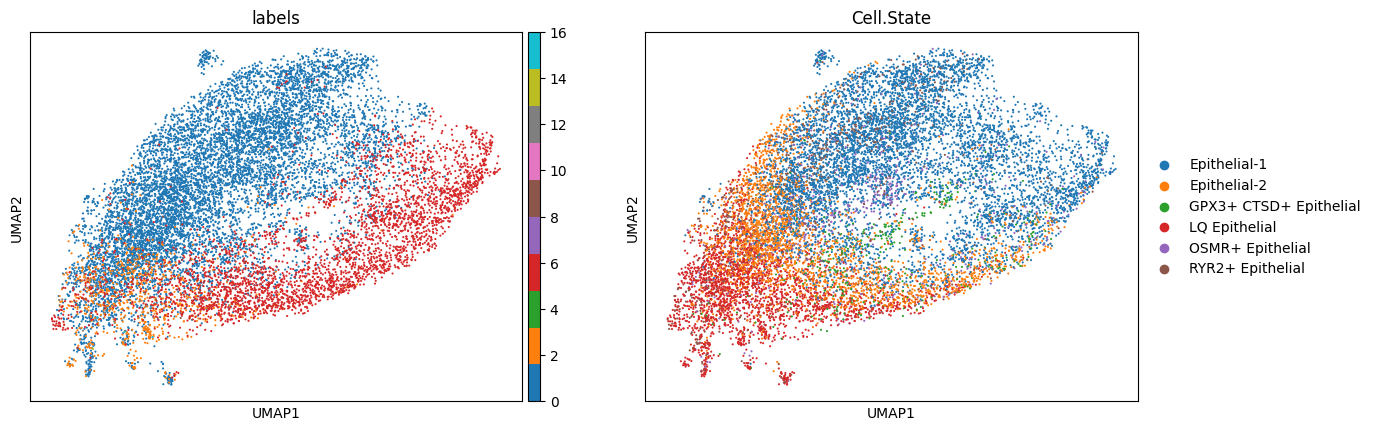

In [77]:
sc.pl.umap(subset, color=["labels", "Cell.State"], cmap="tab10")

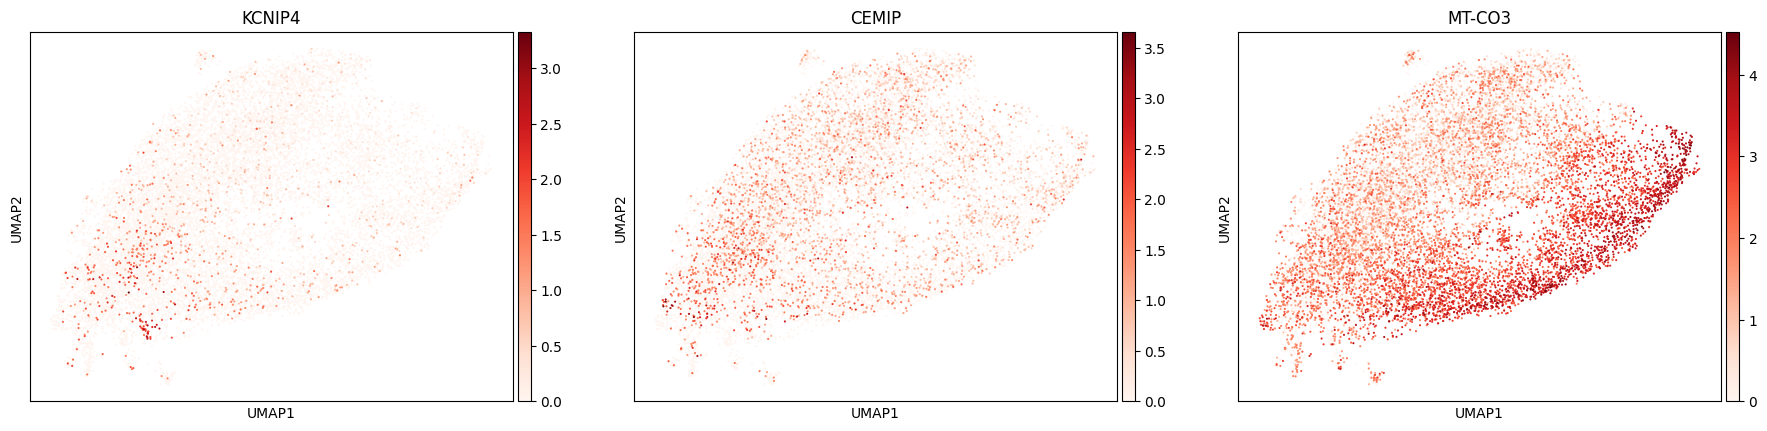

In [91]:
subset_to_normalize = subset.copy()
sc.pp.normalize_total(subset_to_normalize)
sc.pp.log1p(subset_to_normalize)
sc.pl.umap(subset_to_normalize, color=["KCNIP4", "CEMIP", "MT-CO3"], cmap="Reds")

When compared to manual clustering, I would personally argue that this method outperforms standard leiden based clustering.

The downside to this method is, especially for large datasets (100k plus), you're gonna pay upfront. There is no way around this in the current collapsed gibbs sampling format. I may decide to include a keyword argument later for truncated inference (max number of classes at any given point in time will be capped, or there will be a 'staleness' property that determines early truncation during inference), but that will not improve things greatly. If you're willing to wait 20-30 minutes, however, this method will perform extremely well!